This notebook is entirely based on https://www.tensorflow.org/tutorials/images/classification

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
random_seed = 3093453

batch_size = 256
img_height = 180
img_width = 180

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
data_dir = os.path.join(cwd, "dataset")
data_dir

'/Users/fynn/Projects/PokeDex/dataset'

In [4]:
# Before gif: 4421 files
# after Gif 135387
# After Downsampling: 18345
# One per gif: 6633
# with tcg: 20808
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=random_seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=random_seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21675 files belonging to 1008 classes.
Using 17340 files for training.


2023-10-15 12:31:02.645917: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-15 12:31:02.645946: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-15 12:31:02.645949: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-15 12:31:02.646147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-15 12:31:02.646164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 21675 files belonging to 1008 classes.
Using 4335 files for validation.


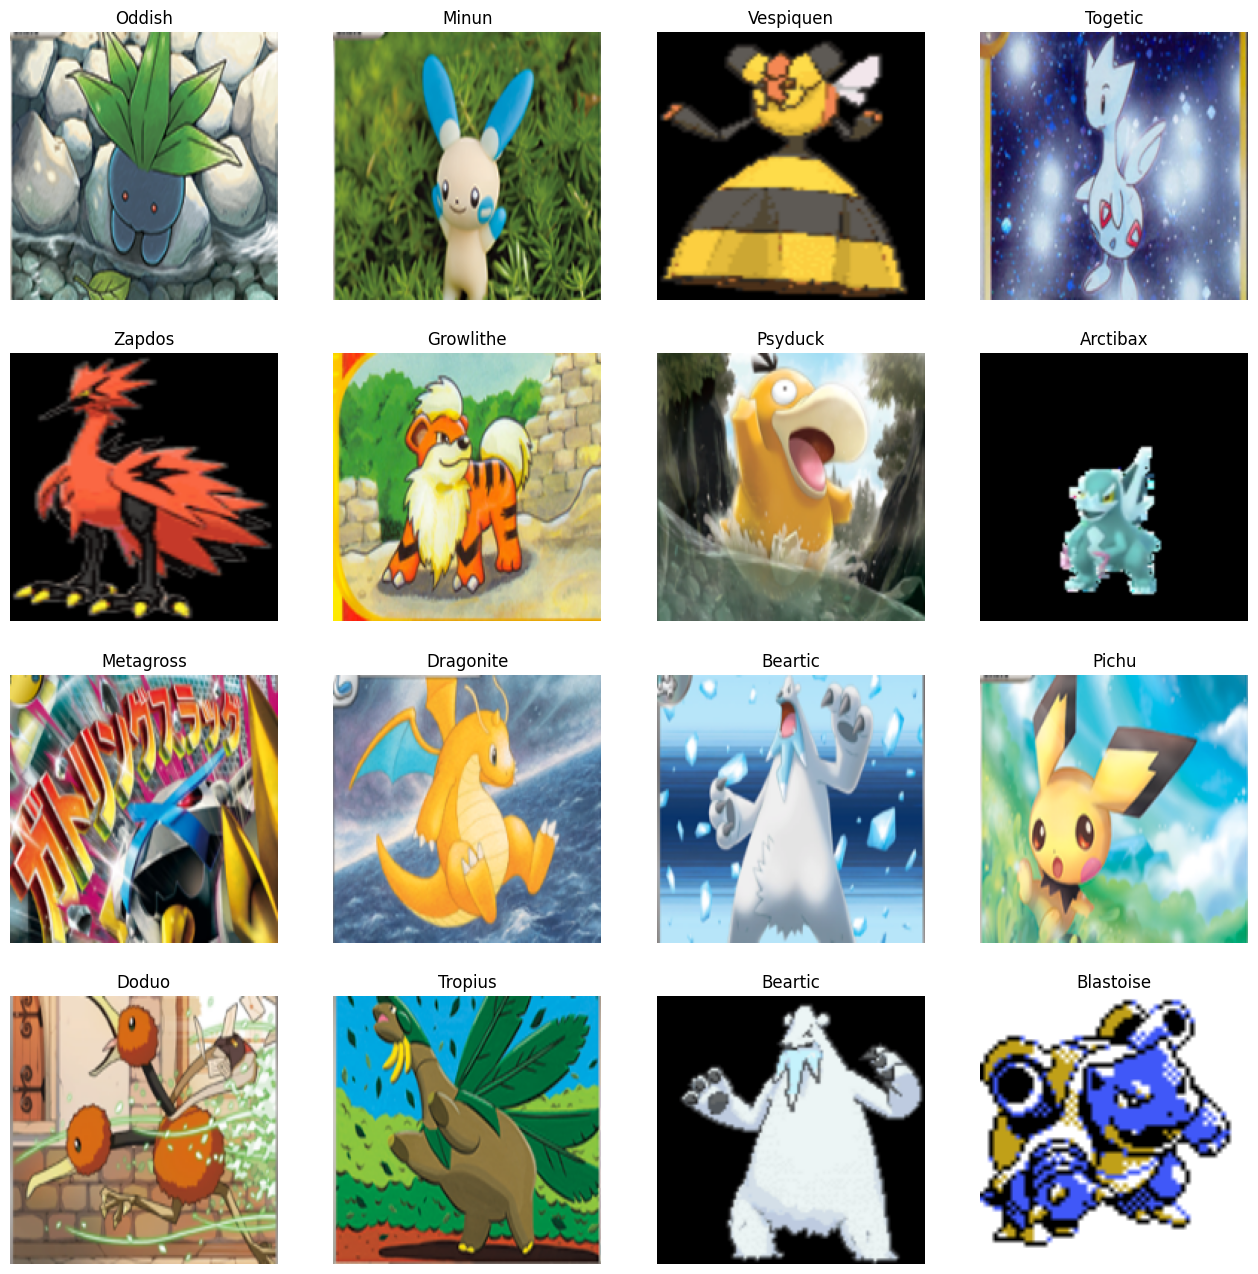

In [5]:
import matplotlib.pyplot as plt

class_names = np.array(train_ds.class_names)

plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [7]:
data_augmentation = keras.Sequential(
  [ 
    layers.RandomTranslation(0.05, 0.05, fill_mode="reflect"),
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.GaussianNoise(20)
  ]
)

2023-10-15 12:31:05.562350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:05.659323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:06.688475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:06.782788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:06.992436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:07.542994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:07.596992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:07.709335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:09.422327: W tensorflow/core/lib/png/png_io.cc:88] PNG 

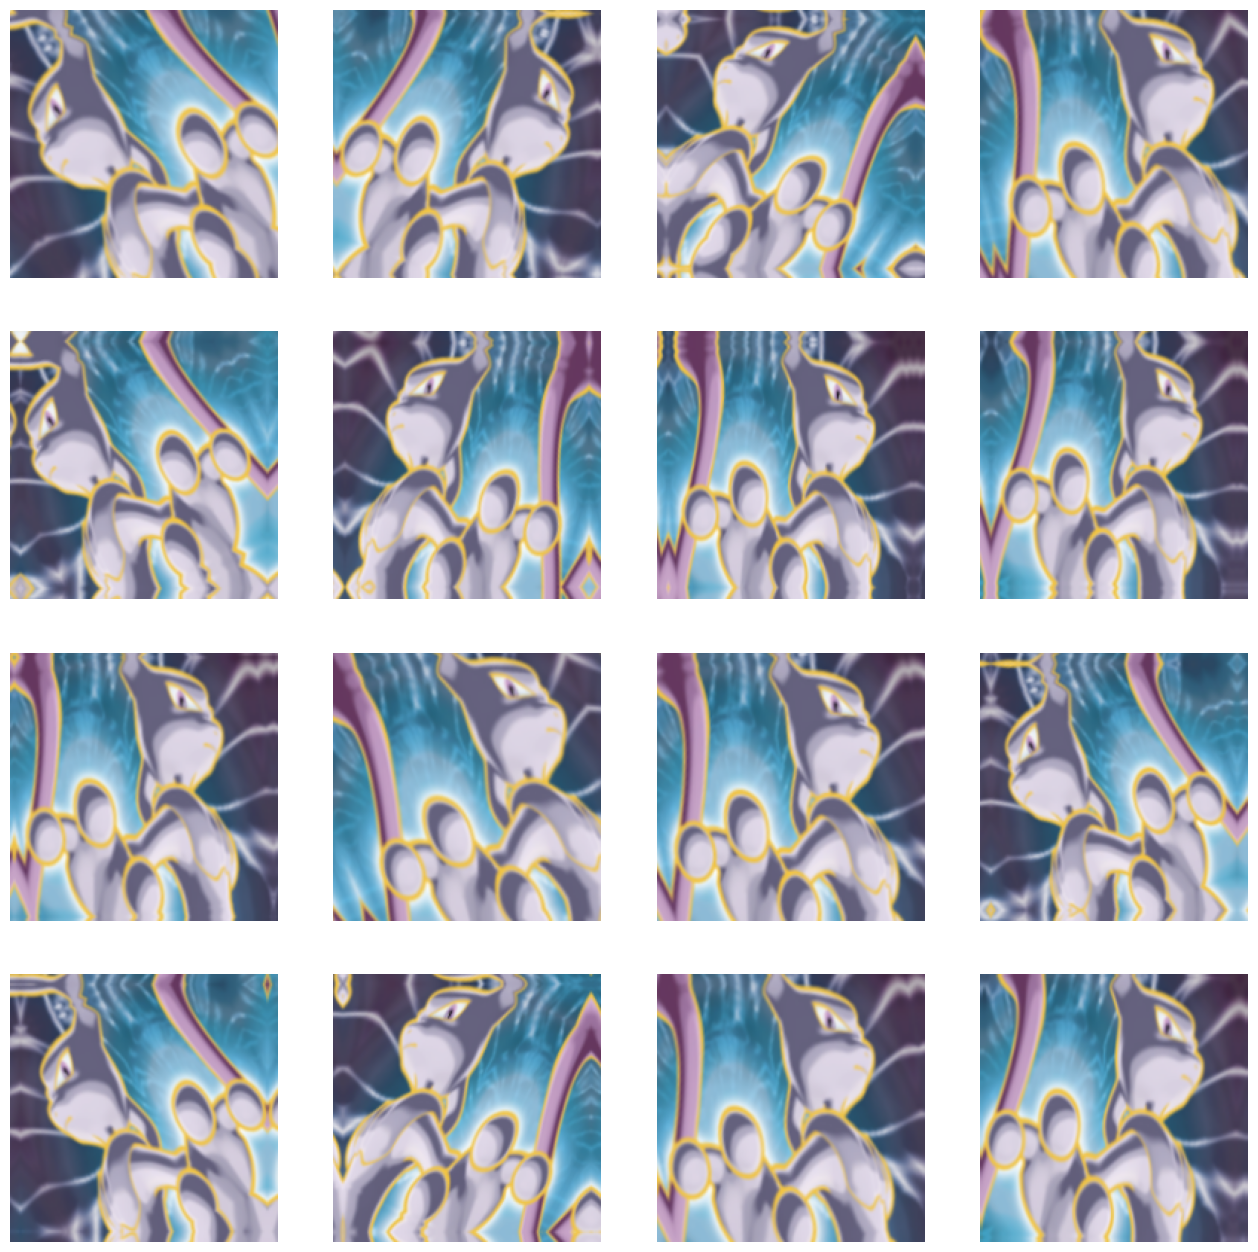

In [8]:
plt.figure(figsize=(16, 16))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

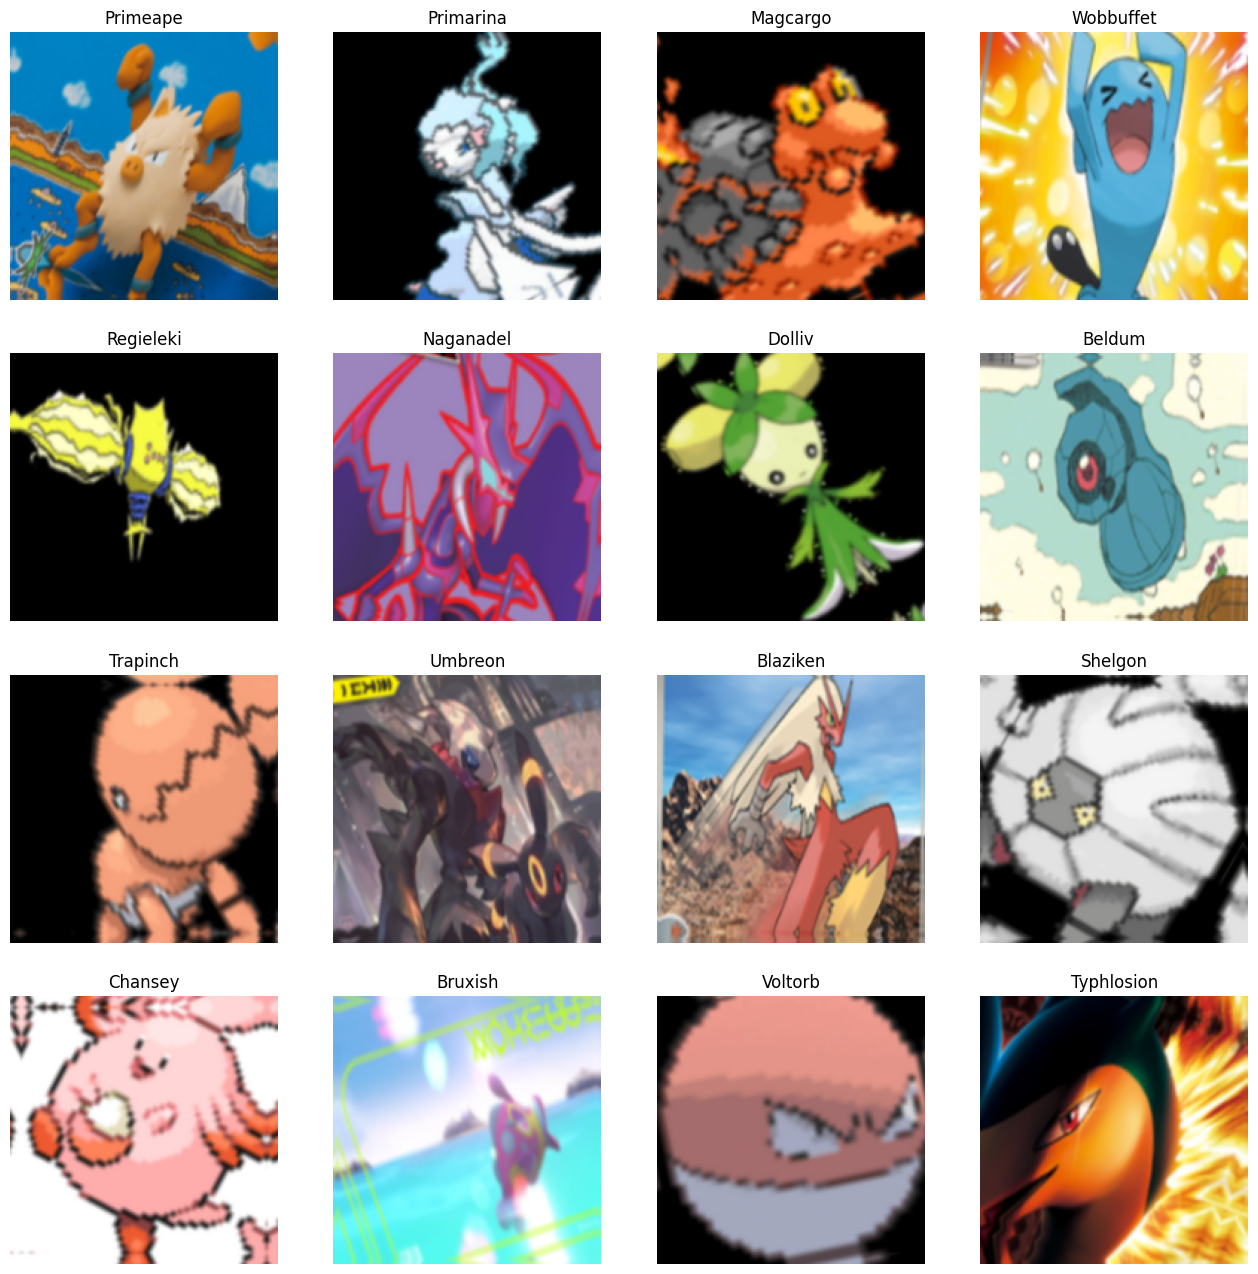

In [9]:
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model

In [10]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.MultiHeadAttention(16, 8),
  layers.Dropout(0.2),
  layers.Dense(num_classes, name="outputs")
])

In [11]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', ])

In [12]:
epochs = 1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping]
)

Epoch 1/1000


2023-10-15 12:31:24.535823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - ETA: 0s - loss: 6.8137 - accuracy: 0.0080

2023-10-15 12:31:54.513698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:54.913955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:55.170286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-15 12:31:55.194382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/68 [==============================] - 34s 463ms/step - loss: 6.8137 - accuracy: 0.0080 - val_loss: 6.6853 - val_accuracy: 0.0081
Epoch 2/1000
68/68 [==============================] - 33s 472ms/step - loss: 6.5003 - accuracy: 0.0165 - val_loss: 6.3115 - val_accuracy: 0.0212
Epoch 3/1000
68/68 [==============================] - 38s 542ms/step - loss: 6.0890 - accuracy: 0.0294 - val_loss: 6.1087 - val_accuracy: 0.0332
Epoch 4/1000
68/68 [==============================] - 37s 536ms/step - loss: 5.7695 - accuracy: 0.0508 - val_loss: 5.9111 - val_accuracy: 0.0431
Epoch 5/1000
68/68 [==============================] - 35s 494ms/step - loss: 5.4370 - accuracy: 0.0834 - val_loss: 6.0470 - val_accuracy: 0.0526
Epoch 6/1000
68/68 [==============================] - 35s 512ms/step - loss: 5.3114 - accuracy: 0.1187 - val_loss: 6.1257 - val_accuracy: 0.0648
Epoch 7/1000
68/68 [==============================] - 31s 450ms/step - loss: 5.2318 - accuracy: 0.1565 - val_loss: 6.9086 - val_accuracy: 0.072

<Axes: >

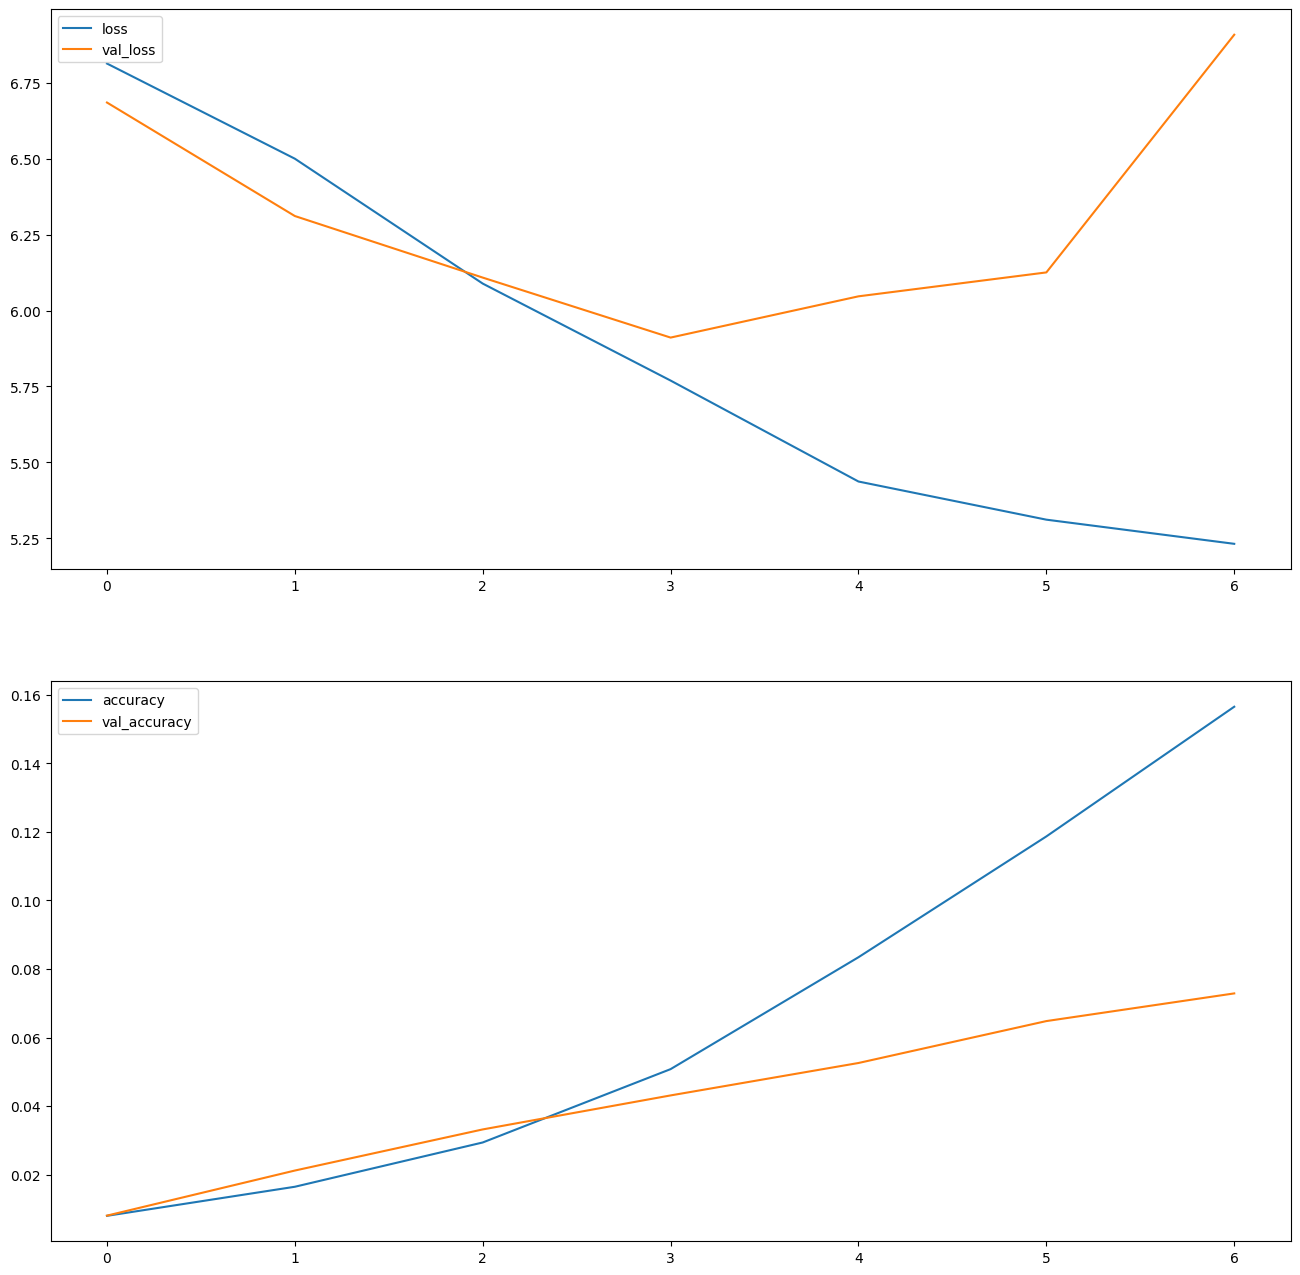

In [13]:
import pandas as pd

df = pd.DataFrame(history.history)

fig, ax = plt.subplots(2, figsize=(16, 16))
df.loc[:,df.columns.str.contains("loss")].plot(ax=ax[0])
df.loc[:,~df.columns.str.contains("loss")].plot(ax=ax[1])

# Predict on new data:

In [17]:
img_path = "/Users/fynn/Desktop/Bildschirmfoto 2023-10-12 um 14.00.48.png" # charizard
#img_path ="/Users/fynn/Desktop/Bildschirmfoto 2023-10-12 um 17.43.15.png" # pikachu
#img_path ="/Users/fynn/Desktop/Bildschirmfoto 2023-10-12 um 17.44.12.png" # charizard mega X

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to Charizard with a 51.19 percent confidence.


In [15]:
class_names[np.argsort(score)][::-1][:10]

array(['Poliwrath', 'Aron', 'Golduck', 'Pineco', 'Samurott', 'Toxicroak',
       'Poliwhirl', 'Quaquaval', 'Metang', 'Whiscash'], dtype='<U12')